# AirBnB Data Cleaning

In [3]:
import pandas as pd
import re
import numpy as np

# Loading Data Files from Airbnb Website

# Data Source Information

The following data is loaded from the Inside Airbnb https://insideairbnb.com/explore/ website. It includes all posted listings at the web scrape snapshot(s), starting from January 2024 to December 2024 from the following United States and Canadian cities:

- New York City
- Los Angeles
- San Francisco
- Asheville
- Chicago
- Austin
- Clark County
- Cambridge
- Miami
- Columbus
- Denver
- Fort Worth
- Hawaii
- Albany
- Bozeman
- Boston
- Dallas
- Nashville
- New Orleans
- Newark
- Oakland
- Portland
- Rhode Island
- Rochester
- Salem
- San Diego
- San Mateo County
- Santa Clara County
- Santa Cruz County
- Seattle
- Twin Cities MSA
- Washington
- Toronto
- Vancouver
- Montreal
- Ottawa
- Calgary
- Victoria


In [4]:
import os
import re
import requests
import gzip
from io import BytesIO
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

#extract all links
base_url = 'https://insideairbnb.com/get-the-data/'
response = requests.get(base_url)
response.raise_for_status()

soup = BeautifulSoup(response.text, 'html.parser')
all_links = soup.find_all('a', href=True)

#filter links by city and date
listing_links = [
    urljoin(base_url, link['href'])
    for link in all_links
    if 'listings.csv.gz' in link['href']
]

#using the following cities (can change whenever)
us_cities = [
    "new-york-city", "los-angeles", "san-francisco", "asheville", "chicago",
    "austin", "clark-county", "cambridge", "miami", "columbus", "denver",
    "fort-worth", "hawaii", "albany", "bozeman", "boston", "dallas", "nashville",
    "new-orleans", "newark", "oakland", "portland", "rhode-island", "rochester",
    "salem-or", "san-diego", "san-mateo-county", "santa-clara-county",
    "santa-cruz-county", "seattle", "twin-cities-msa", "washington-dc"
]

#canadian_cities = ["toronto", "vancouver", "montreal", "ottawa", "calgary", "victoria"]

#currently not using but in case we do want to use it
#euro_cities = ["paris", "berlin", "rome", "barcelona", "madrid", "lisbon", "vienna", "amsterdam", "brussels", "dublin"]

city_list = us_cities

#convert all the currencies to USD
country_to_currency = {
    "united-states": "USD",
    #"canada": "CAD",
    #"france": "EUR", "germany": "EUR", "italy": "EUR", "spain": "EUR", "portugal": "EUR", "austria": "EUR", "netherlands": "EUR", "belgium": "EUR", "ireland": "EUR"
}

currency_to_usd = {
    "USD": 1.00,
    #"CAD": 0.74,
    #"EUR": 1.09
}

#filter by date and city,
date_pattern = re.compile(r'(\d{4}-\d{2}-\d{2})')
start_date = '2024-12-01'
end_date   = '2025-03-31'

filtered_links = []
for url in listing_links:
    match = date_pattern.search(url)
    if not match:
        continue
    file_date = match.group(1)
    if not (start_date <= file_date <= end_date):
        continue
    if any(city in url for city in city_list):
        filtered_links.append(url)

#consolidate data
consolidated_data = pd.DataFrame()

for url in filtered_links:
    try:
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with gzip.GzipFile(fileobj=BytesIO(r.content)) as gz:
            df = pd.read_csv(gz, low_memory=False)
        if 'price' not in df.columns:
            continue

        df['price'] = pd.to_numeric(
            df['price'].astype(str).str.replace(r'[\$,]', '', regex=True),
            errors='coerce')
        
        df.dropna(subset=['price'], inplace=True)
    
        parts = urlparse(url).path.split('/')
        matched_country = parts[1] if len(parts) >= 2 else "unknown"
        matched_city = next((city for city in city_list if city in url), "unknown")
        file_date = date_pattern.search(url).group(1)
    
        currency = country_to_currency.get(matched_country, "USD")
        df['price_usd'] = df['price'] * currency_to_usd.get(currency, 1.0)
    
        df['file_date'] = file_date
        df['city'] = matched_city
        df['country'] = matched_country
    
        consolidated_data = pd.concat([consolidated_data, df], ignore_index=True)

    except Exception as e:
        print(f"Failed {url}: {e}")
        continue

print("Data collection complete. Ready to go!")




Data collection complete. Ready to go!


In [5]:
df = consolidated_data.copy()
df_backup = df.copy()

In [6]:
df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_usd,file_date,city,country
0,621960198566758900,https://www.airbnb.com/rooms/621960198566758900,20250302010353,2025-03-02,city scrape,The Historic Jesse Buel Farmhouse w/ Heated Pool,4800ft of living space and an epic backyard ma...,"Walkable, Safe and quiet",https://a0.muscache.com/pictures/dd1a2e33-d50b...,382970529,...,f,12,2,10,0,0.47,882.0,2025-03-02,albany,united-states
1,932642358896439621,https://www.airbnb.com/rooms/932642358896439621,20250302010353,2025-03-02,city scrape,Stylish top floor apt w/parking,The whole group will enjoy easy access to ever...,Pine Hills Neighborhood in Albany NY is full o...,https://a0.muscache.com/pictures/prohost-api/H...,232967878,...,f,23,23,0,0,1.88,106.0,2025-03-02,albany,united-states
2,53567589,https://www.airbnb.com/rooms/53567589,20250302010353,2025-03-02,city scrape,Private Garden Apt in Downtown Albany|Pets All...,Discover Lark Street - A Hip Albany Neighborho...,If you visit Albany’s Capital Region without s...,https://a0.muscache.com/pictures/2e5b6926-a177...,433096110,...,f,4,4,0,0,6.40,99.0,2025-03-02,albany,united-states
3,20671966,https://www.airbnb.com/rooms/20671966,20250302010353,2025-03-02,city scrape,The Metropolitan,This full apartment is located on the 3rd floo...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,98744672,...,f,8,2,6,0,0.51,58.0,2025-03-02,albany,united-states
4,24606880,https://www.airbnb.com/rooms/24606880,20250302010353,2025-03-02,city scrape,The Western Suite,"Located in a huge Victorian, this beautiful su...",NaN,https://a0.muscache.com/pictures/e8183a7b-a392...,98744672,...,f,8,2,6,0,0.62,50.0,2025-03-02,albany,united-states


In [7]:
print(df.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Dropping unnecessary columns
The following are unlikely to be incorporated into any regression models and ignored for cleaning:
- Long text values
- URLs
- IDs
- Scraping metadata
- Some host metadata
- Timed review metrics (e.g., last month, last 30days) - these will quickly become outdated as the data is pulled
- `property_type` - might be useful to classify somehow, but as of now it seems too high-dimensional to gain much over `room_type`

In [8]:
df = df.drop([
    'id', 'listing_url', 'scrape_id', 
    'last_scraped', 'source', 'name', 
    'description', 'neighborhood_overview', 
    'picture_url', 'host_id', 'host_url', 'host_name',
    'host_location', 'host_about', 'host_response_time',
    'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic',
    'host_neighbourhood', 'neighbourhood', 'bathrooms', 'host_verifications',
    'calendar_last_scraped', 'number_of_reviews_ltm', 'calendar_updated',
    'number_of_reviews_l30d', 'first_review', 'last_review', 'property_type'
], axis = 1)

## Cleaning Numeric Data

In [9]:
df['host_response_rate'] = df['host_response_rate'].apply(lambda x: float(str(x).replace('%', '')) / 100)
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x: float(str(x).replace('%', '')) / 100)

In [10]:
def extract_bathroom_num(bathroom_text):
    matches = re.findall(r'[\d\.]+', bathroom_text)
    if len(matches) == 0:
        return np.nan
    else:
        return(float(matches[0]))
    


In [11]:
#df['bathrooms_text'] = df['bathrooms_text'].apply(lambda x: extract_bathroom_num(x))

## Cleaning Dates

In [12]:
df['host_since'] = pd.to_datetime(df['host_since'], format = '%Y-%m-%d')

## Cleaning Categories

In [13]:
df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
df['has_availability'] = df['has_availability'].apply(lambda x: 1 if x == 't' else 0)
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
df['host_identity_verified'] = df['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)

In [14]:
df['room_type'] = df['room_type'].apply(lambda x: x.replace(' ', '_').replace('/', '_').lower())
df = pd.concat([df, pd.get_dummies(df['room_type'], prefix = 'room_type', dtype='int')], axis = 1)
df.drop('room_type', axis = 1, inplace = True)

In [15]:

#Extras when deving 
df_backup2 = df.copy()
df_backup3 = df.copy()
df_backup4 = df.copy()
df_backup5 = df.copy()


In [16]:
# make a tenure var instead of host_since
df['host_since'] = pd.to_datetime(df['host_since'])
df['tenure'] = (pd.to_datetime('today') - df['host_since']).dt.days / 365
df['tenure'] = df['tenure'].round(2)
df = df.drop(columns=['host_since'])


In [17]:
# make one date variable for year, month, day
df['date'] = pd.to_datetime(df['file_date'])
df = df.drop(columns=['file_date'])


In [18]:

print(list(df.columns))
print(df['price'].dtype)
df['price'] = df['price'].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)
print(df['price'].dtype)
print(df['price'])


['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_enti

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
print(df)
print(list(df.columns))
print(df['neighbourhood_cleansed'])
print(df['price'])
df = df.drop(columns=['neighbourhood_cleansed'])


        host_response_rate  host_acceptance_rate  host_is_superhost  \
0                     1.00                  0.98                  1   
1                     0.99                  0.97                  1   
2                     1.00                  0.94                  1   
3                     1.00                  0.98                  1   
4                     1.00                  0.98                  1   
...                    ...                   ...                ...   
213179                1.00                  0.96                  0   
213180                 NaN                   NaN                  0   
213181                1.00                  0.93                  0   
213182                 NaN                   NaN                  0   
213183                1.00                  0.84                  1   

        host_listings_count  host_total_listings_count  \
0                      12.0                       24.0   
1                      25.0    

In [20]:
print(list(df.columns))
print(df['bathrooms_text'])
df['num_bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)')
df['num_bathrooms'] = df['num_bathrooms'].astype(float)
print(df[['bathrooms_text', 'num_bathrooms']])
df = df.drop(columns=['bathrooms_text'])


['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_hos

In [21]:
print(list(df.columns))
print(df.head(5))
print(df['neighbourhood_group_cleansed'])
df = df.drop(columns=['neighbourhood_group_cleansed'])

['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_p

In [22]:
from sklearn.preprocessing import LabelEncoder
import ast

print(df.columns)
print(list(df.dtypes))
print(df.select_dtypes(include=['object']).columns)

if 'amenities' in df.columns:
    df['num_amenities'] = df['amenities'].apply(
        lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0
    )
    df = df.drop(columns=['amenities'], errors='ignore')

df = df.drop(columns=['license'], errors='ignore')

if 'city' in df.columns:
    df['city_encoded'] = LabelEncoder().fit_transform(df['city'])



Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'availability_eoy',
       'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'instant_bookable', 'calculated_host_listings_count',
       '

In [23]:
print(df.select_dtypes(include=['object']).columns)
refDate = df['date'].min()
df['date'] = (df['date'] - refDate).dt.days


Index(['city', 'country'], dtype='object')


In [24]:
low_importance_features = [
    "room_type_shared_room", "room_type_hotel_room", "room_type_private_room",
    "availability_eoy", "number_of_reviews_ly", "host_identity_verified",
    "room_type_entire_home_apt", "instant_bookable",
    "review_scores_communication", "estimated_occupancy_l365d"
]
low_importance_features_2 = [
    "minimum_nights", "maximum_maximum_nights",
    "review_scores_accuracy", "availability_30", "host_acceptance_rate",
    "maximum_minimum_nights", "calculated_host_listings_count_shared_rooms",
    "minimum_minimum_nights"
]
df = df.drop(columns=low_importance_features, errors='ignore')
df = df.drop(columns=low_importance_features_2, errors='ignore')

In [25]:

df_numeric = df.select_dtypes(include=['number'])
df_numeric = df_numeric.fillna(df_numeric.median())

#remove outliers
df_numeric = df_numeric[(df_numeric['price'] >= 30) & (df_numeric['price'] <= 1000)]


print(df_numeric)
# Define features and target
target = 'price'
X = df_numeric.drop(columns=[target, 'price_usd'], errors='ignore')
y = df_numeric[target]


        host_response_rate  host_is_superhost  host_listings_count  \
0                     1.00                  1                 12.0   
1                     0.99                  1                 25.0   
2                     1.00                  1                  4.0   
3                     1.00                  1                  8.0   
4                     1.00                  1                  8.0   
...                    ...                ...                  ...   
213179                1.00                  0                  4.0   
213180                1.00                  0                  1.0   
213181                1.00                  0                  3.0   
213182                1.00                  0                  1.0   
213183                1.00                  1                 35.0   

        host_total_listings_count   latitude  longitude  accommodates  \
0                            24.0  42.667620 -73.799190            12   
1            

In [26]:
print(X,y)
print(X.shape, y.shape)


        host_response_rate  host_is_superhost  host_listings_count  \
0                     1.00                  1                 12.0   
1                     0.99                  1                 25.0   
2                     1.00                  1                  4.0   
3                     1.00                  1                  8.0   
4                     1.00                  1                  8.0   
...                    ...                ...                  ...   
213179                1.00                  0                  4.0   
213180                1.00                  0                  1.0   
213181                1.00                  0                  3.0   
213182                1.00                  0                  1.0   
213183                1.00                  1                 35.0   

        host_total_listings_count   latitude  longitude  accommodates  \
0                            24.0  42.667620 -73.799190            12   
1            

# Model Training (Random Forest Regression)

In [27]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle missing values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())



In [48]:
print("city_encoded" in X_train.columns)

True


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Train model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_regressor.fit(X_train, y_train)

feature_importances = pd.Series(rf_regressor.feature_importances_, index=X_train.columns)


In [45]:
print(feature_importances.sort_values(ascending=False).head(20))



accommodates                                    0.423854
num_bathrooms                                   0.109652
longitude                                       0.102747
estimated_revenue_l365d                         0.077768
latitude                                        0.034490
date                                            0.033942
host_total_listings_count                       0.030115
reviews_per_month                               0.028592
minimum_nights_avg_ntm                          0.026759
calculated_host_listings_count_private_rooms    0.017584
review_scores_location                          0.015365
host_listings_count                             0.012078
tenure                                          0.009899
city_encoded                                    0.008843
number_of_reviews                               0.008606
calculated_host_listings_count_entire_homes     0.007629
calculated_host_listings_count                  0.007623
num_amenities                  

<!-- room_type_shared_room          0.000013
room_type_hotel_room           0.000018
room_type_private_room         0.000268
availability_eoy               0.000335
number_of_reviews_ly           0.000344
host_identity_verified         0.000382
room_type_entire_home_apt      0.000490
instant_bookable               0.000582
review_scores_communication    0.000905
estimated_occupancy_l365d      0.001163 -->

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Metrics
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

Train R²: 0.6603711504316853
Test R²: 0.6310135335051006
Train MAE: 62.984160838751194
Test MAE: 65.20535689994212
Train RMSE: 99.6032404253491
Test RMSE: 103.0831285203569


TypeError: 'module' object is not subscriptable

In [31]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print(comparison.head(20))

        Actual   Predicted
165693    57.0   82.538889
112394   167.0  162.000139
35496    104.0  125.981944
191674    75.0   76.808500
170563   152.0  173.859701
133977   200.0  181.286138
51874    131.0  404.016906
205056   191.0  207.559810
10485    120.0  109.700911
103728   162.0  109.625398
210122   249.0   76.808500
5348     202.0  295.143297
24863     69.0  144.367352
69144    262.0  310.256390
166791   122.0  164.677973
90295     52.0   77.118671
96868    225.0  253.503719
273      149.0  223.400632
55715    303.0  474.596517
30885    253.0  208.893476


# Trend Analysis

Using the Airbnb cleaned dataset, we want to explore the following:
1. Feature Importance
2. Average Price over Time
3. Price vs Number of Amenities (idk could remove not really important)
4. Price vs Bedroom Count
5. Overall Rating vs Cleanliness Rating
6. Average Price per City
7. Geomapping Price
8. Most Profitable Market


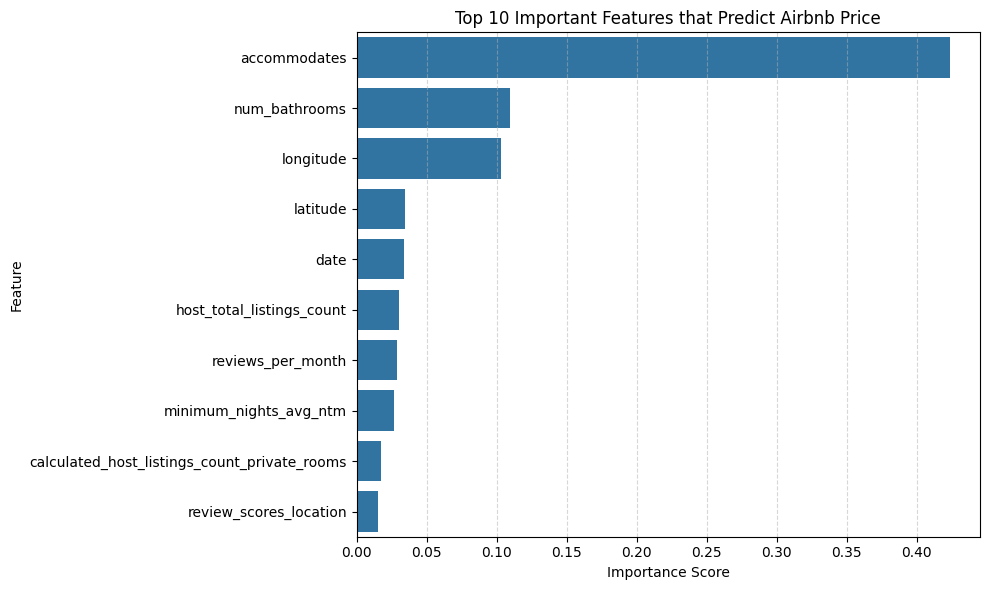

In [32]:
#feature importance bar plot

import matplotlib.pyplot as plt
import seaborn as sns


#excludes 'price_usd' and 'estimated_revenue_365d' from the plot
cleaned_importances = feature_importances.drop(labels=['price_usd', 'estimated_revenue_365d', 'estimated_revenue_l365d'], errors='ignore')

#sort and get top ten most important features
sorted_importances = cleaned_importances.sort_values(ascending=False).head(10)

#importnace scores for colour mapping
plt.figure(figsize=(10, 6))
sns.barplot(
    x=sorted_importances.values,
    y=sorted_importances.index, 
)
plt.title("Top 10 Important Features that Predict Airbnb Price")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


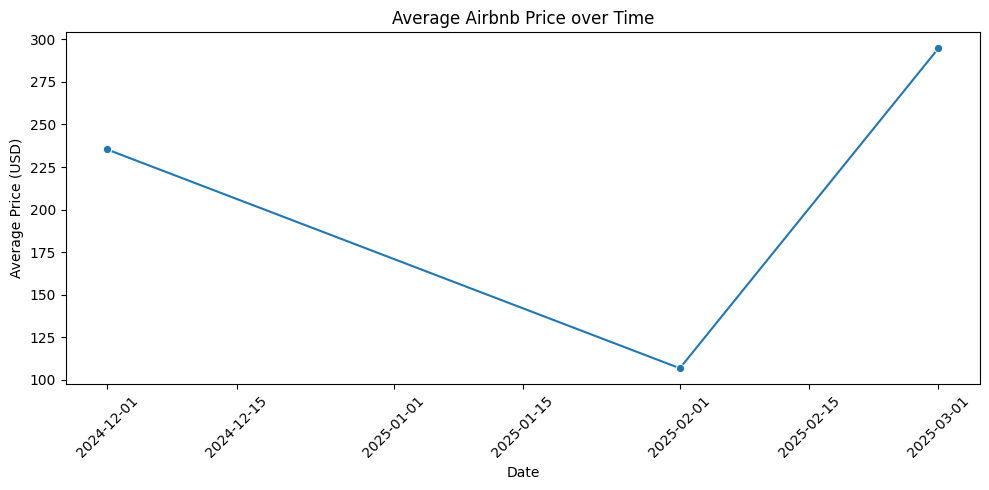

In [33]:
#average price over time

#just usa data doesnt provide enough months so thats why the plot looks like that, when including europe+canadian cities it had a couple more months

df = df_backup3.copy()

df['date'] = pd.to_datetime(df['file_date'])

df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

price_trend = df.groupby('month', as_index=False)['price_usd'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=price_trend, x='month', y='price_usd', marker='o')
plt.title('Average Airbnb Price over Time')
plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


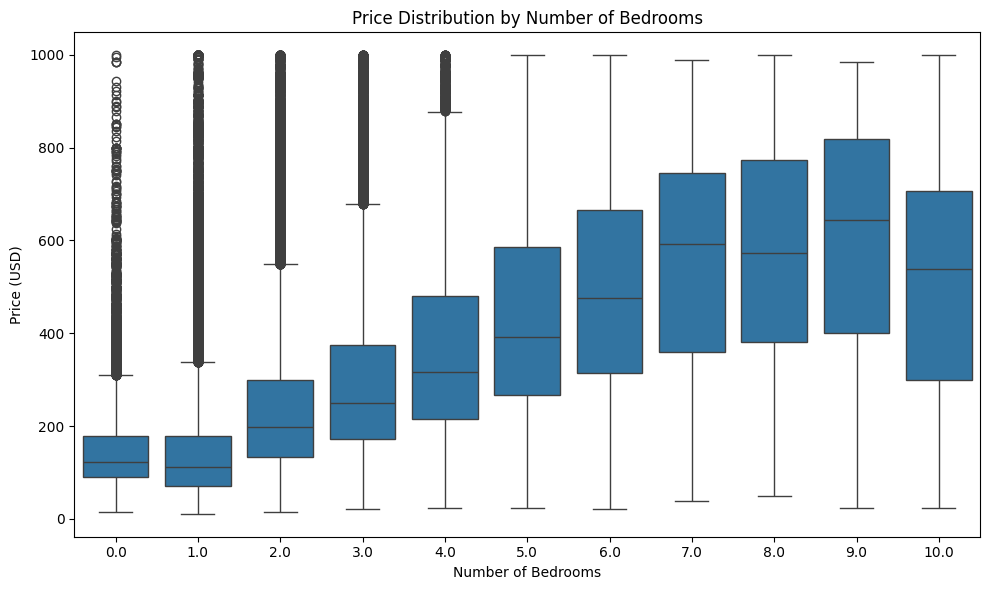

In [34]:
#bedroom count trends

df_filtered = df[(df['price_usd'] > 10) & (df['price_usd'] < 1000) & (df['bedrooms'] <= 10)]

df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['price_usd'] = pd.to_numeric(df['price_usd'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='bedrooms', y='price_usd')
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()




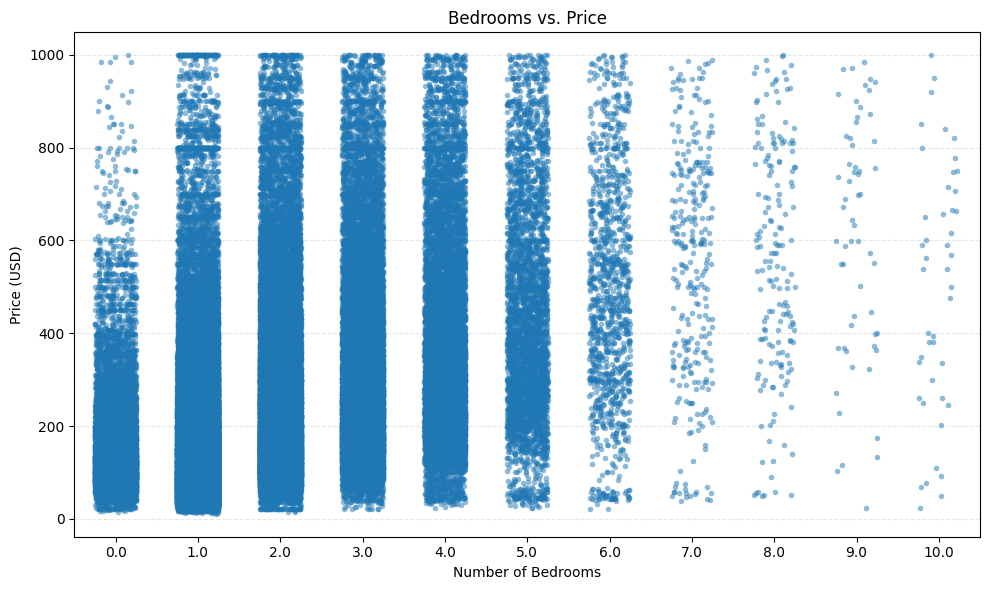

In [35]:
#bedroom count trends

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df_filtered,
    x='bedrooms',
    y='price_usd',
    alpha=0.5,
    jitter=0.25,
    size=4,
    color='tab:blue'
)
plt.title('Bedrooms vs. Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



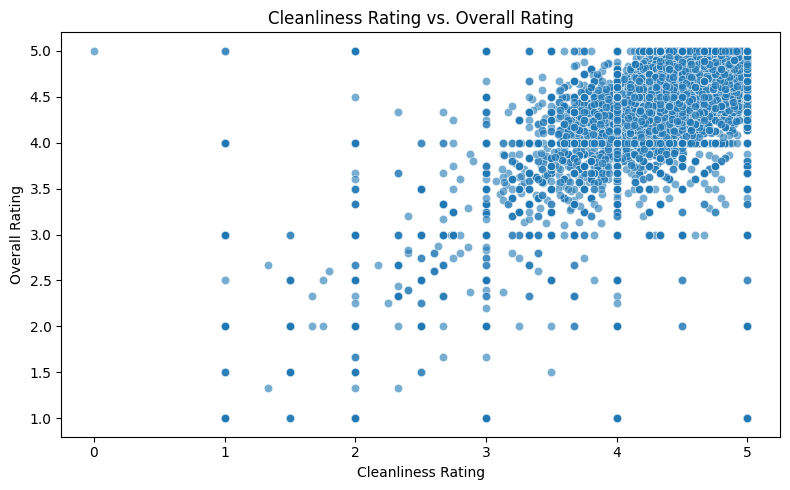

In [36]:
#review score trends

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='review_scores_cleanliness', y='review_scores_rating', alpha=0.6)
plt.title('Cleanliness Rating vs. Overall Rating')
plt.xlabel('Cleanliness Rating')
plt.ylabel('Overall Rating')
plt.tight_layout()
plt.show()


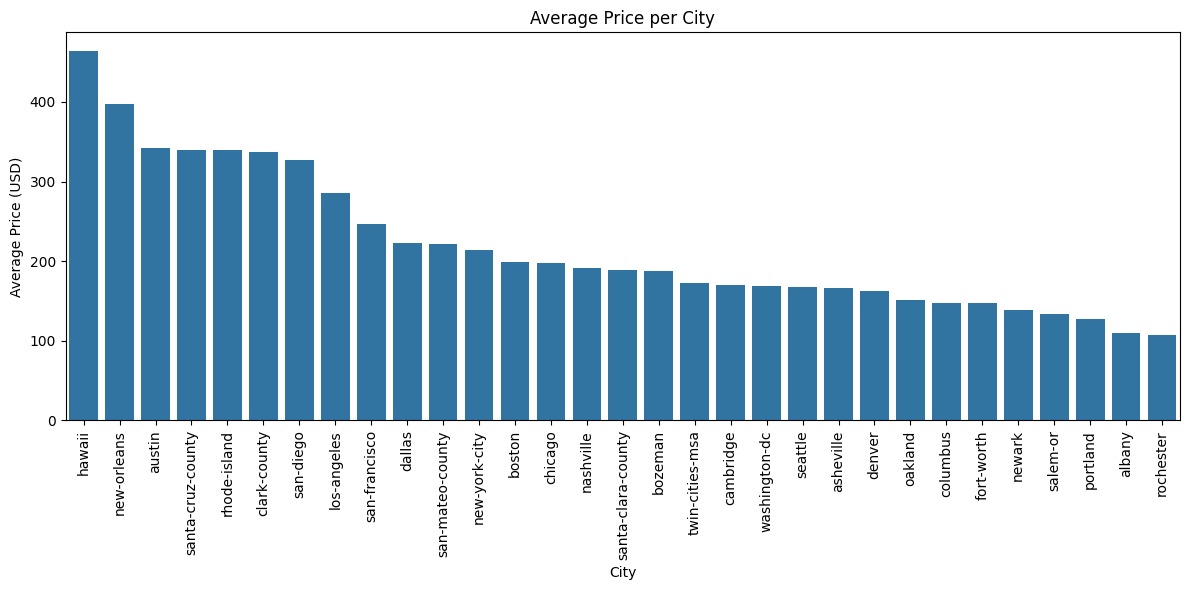

In [37]:
#average price or revenue per city

df_city_avg = df.groupby('city')[['price', 'estimated_revenue_l365d']].mean().sort_values('price', ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_city_avg, x='city', y='price')
plt.title('Average Price per City')
plt.xlabel('City')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


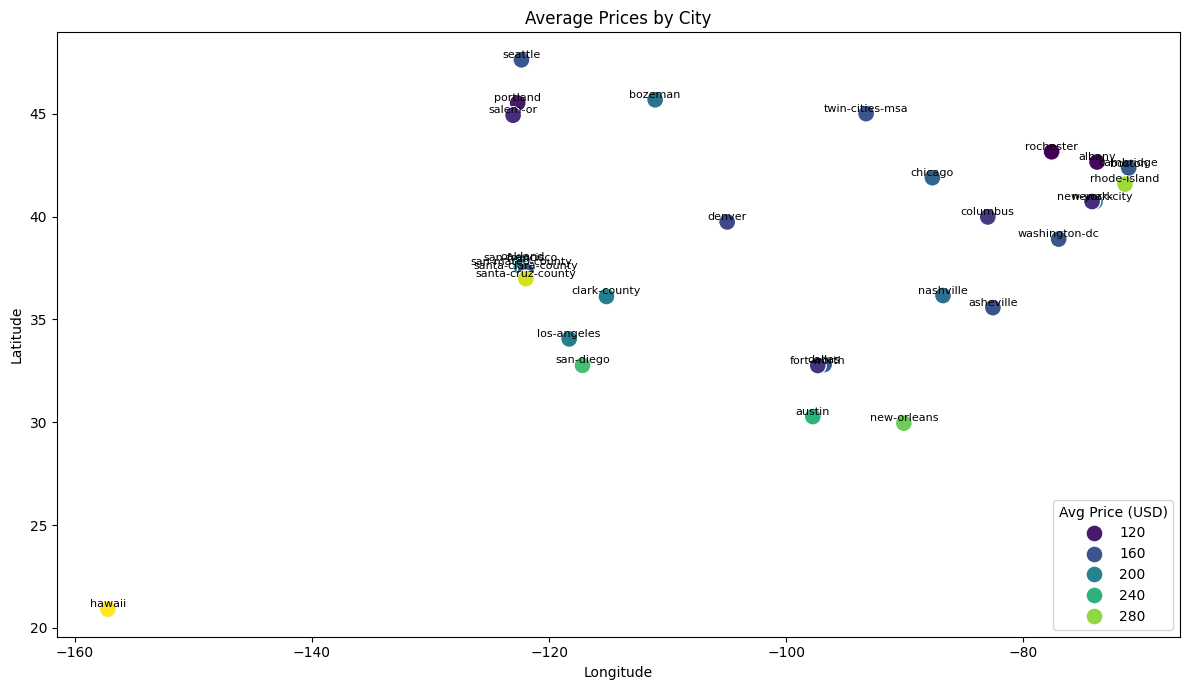

In [38]:
#geo mapping of listings

df_filtered = df[(df['price_usd'] > 10) & (df['price_usd'] < 1000)]

city_summary = df_filtered.groupby('city').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'price_usd': 'mean'
}).reset_index()

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=city_summary,
    x='longitude',
    y='latitude',
    hue='price_usd',
    palette='viridis',
    s=150
)

for _, row in city_summary.iterrows():
    plt.text(
        row['longitude'], row['latitude'],
        row['city'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

plt.title('Average Prices by City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Avg Price (USD)', loc='lower right')
plt.tight_layout()
plt.show()




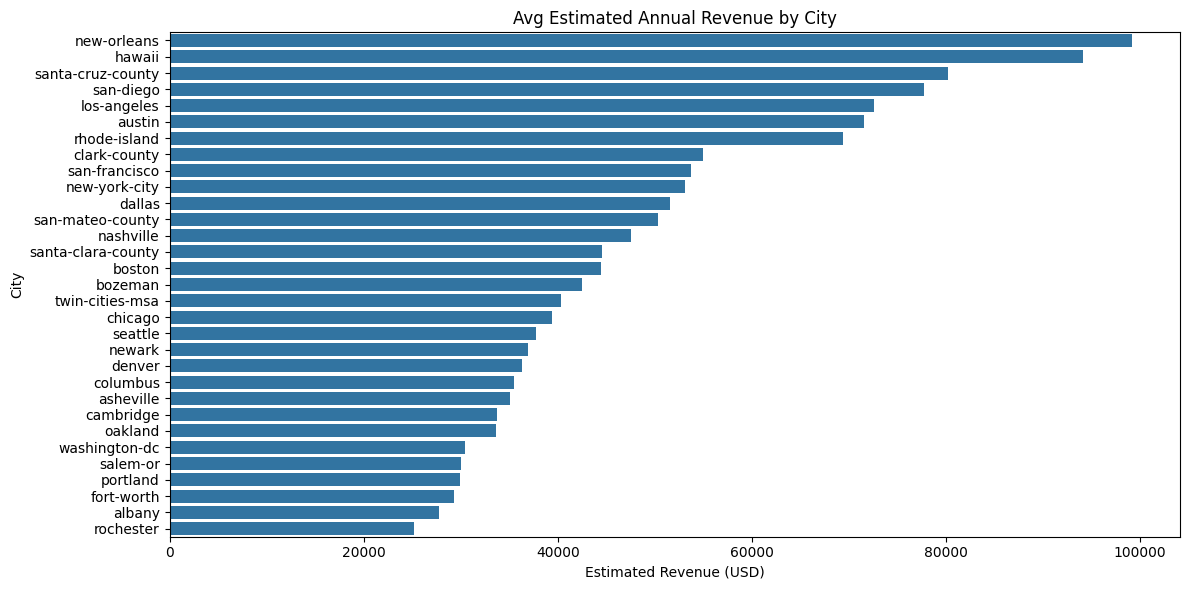

In [39]:
#price * availability
df['estimated_annual_revenue'] = df['price_usd'] * df['availability_365']
city_revenue = df.groupby('city')['estimated_annual_revenue'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=city_revenue.values, y=city_revenue.index)
plt.title('Avg Estimated Annual Revenue by City')
plt.xlabel('Estimated Revenue (USD)')
plt.ylabel('City')
plt.tight_layout()
plt.show()


In [40]:
import pickle

# Save model to disk
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_regressor, f)

# Save feature columns too
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

In [46]:
city_encoder = LabelEncoder()
df['city_encoded'] = city_encoder.fit_transform(df['city'])

# Save encoder
with open('city_encoder.pkl', 'wb') as f:
    pickle.dump(city_encoder, f)

In [41]:
pd.Series(rf_regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

accommodates                                    0.423854
num_bathrooms                                   0.109652
longitude                                       0.102747
estimated_revenue_l365d                         0.077768
latitude                                        0.034490
date                                            0.033942
host_total_listings_count                       0.030115
reviews_per_month                               0.028592
minimum_nights_avg_ntm                          0.026759
calculated_host_listings_count_private_rooms    0.017584
dtype: float64